# Project : python for data analysis

## Bruno Pincet, Quentin Navarre


### Table of Contents

* [1. Preprocessing](#chapter1)
* [2. Data Analysis](#chapter2)
* [3. Machine Learning](#chapter3)
    * [a/ Dataset](#section_3_1)
        * [Variance Treshold](#section_3_1_1)
        * [Get Dummies & Scaled Data](#section_3_1_2)
        * [Removing Correlated Features](#section_3_1_3)
    * [b. Supervised learning Model](#section_3_2)
        * [Linear SVC](#section_3_2_1)
            * [1.Normal](#section_3_2_1_1)
            * [2.Optimization - Recursive Feature Elimination and Grid Search](#section_3_2_1_2)
        * [KNeighborsClassifier](#section_3_2_2)
            * [1.Normal](#section_3_2_2_1)
            * [2.Optimization - Grid Search](#section_3_2_2_2)
        * [SVC](#section_3_2_3)
            * [1.Normal](#section_3_2_3_1)
            * [2.Optimization - Recursive Feature Elimination and Grid Search](#section_3_2_3_2)
        * [Random Forest](#section_3_2_4)
            * [1.Normal](#section_3_2_4_1)
            * [2.Optimization - Feature Elimination and Grid Search](#section_3_2_4_2)
    * [c. Deep Learning](#section_3_3)

    

### Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#import geopandas as geo
import seaborn as sns
import folium
import random
import tensorflow as tf

from mapping_data import *
from pywaffle import Waffle
from IPython.display import Image,IFrame
from sklearn.feature_selection import VarianceThreshold,SelectFromModel,RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split,cross_val_score,ShuffleSplit,StratifiedKFold,GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tensorflow import keras
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings('ignore')

### Dataset source: 

In [3]:
IFrame('https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29', width=800, height=450)

## 1.Preprocessing <a class="anchor" id="chapter1"></a>

In [4]:
df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data")


In [5]:
df.head()

,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0.4,CL0.5,CL0.6,CL0.7,CL0.8,CL0.9,CL0.10,CL2.2,CL0.11,CL0.12
0,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0


CL0 : Never Used \
CL1 : Used over a Decade Ago \
CL2 : Used in Last Decade \
CL3 : Used in Last Year\
CL4 : Used in Last Month \ 
CL5 : Used in Last Week \
CL6 : Used in Last Day 

In [6]:
#Adding the names of the columns :

df.loc[len(df)]=df.columns
df.columns=(["id","age","gender","education","country","ethnicity","nscore","escore","oscore","ascore","cscore","impulsive","ss",
 "alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke","crack","ecstasy","heroin","ketamine","legalh",
 "lsd","meth","mushrooms","nicotine","semer","vsa"])
df["id"]=df["id"].astype(int) 
df = df.set_index("id")
df.sort_index(inplace=True)
for i in range(12):
    df.iloc[:,i]=df.iloc[:,i].astype(float)
df.head()


,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
id,,,,,,,,,,,,,,,,,,,,,
1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0.4,CL0.5,CL0.6,CL0.7,CL0.8,CL0.9,CL0.10,CL2.2,CL0.11,CL0.12
2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


In [7]:
#Mapping the numeric values : 

df["age"]=df.age.map(age)
df["gender"]=df.gender.map(gender)
df["education"]=df.education.map(education)
df["country"]=df.country.map(country)
df["ethnicity"]=df.ethnicity.map(ethnicity)
df["nscore"]=df.nscore.map(nscore)
df["escore"]=df.escore.map(escore)
df["oscore"]=df.oscore.map(oscore)
df["ascore"]=df.ascore.map(ascore)
df["cscore"]=df.cscore.map(cscore)

drug_list=["alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke","crack","ecstasy","heroin","ketamine","legalh",
          "lsd","meth","mushrooms","nicotine","semer","vsa"]

for i in drug_list:
    df[i].replace(drogue, inplace=True)

In [8]:
dfnan = df[df.isna().any(axis=1)]
#we observe that Nan value wich correspond to unreferenced value in the documentation correspond only to the ID 1.
#Thus we have decided to drop this row from our dataframe.
df=df.iloc[1:]
df.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,...,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
id,,,,,,,,,,,,,,,,,,,,,
2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,...,Used in Last Month,Never Used,Used in Last Decade,Never Used,Used in Last Decade,Used in Last Year,Never Used,Used in Last Month,Never Used,Never Used
3,35-44,Male,Professional certificate/ diploma,UK,White,31,45,40,32,34,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Never Used
4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,...,Never Used,Never Used,Used in Last Decade,Never Used,Never Used,Never Used,Never Used,Used in Last Decade,Never Used,Never Used
5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,...,Used over a Decade Ago,Never Used,Never Used,Used over a Decade Ago,Never Used,Never Used,Used in Last Decade,Used in Last Decade,Never Used,Never Used
6,65+,Female,Left school at 18 years,Canada,White,29,38,35,55,52,...,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Never Used,Used in Last Day,Never Used,Never Used


## 2. Data Analysis <a class="anchor" id="chapter2"></a>

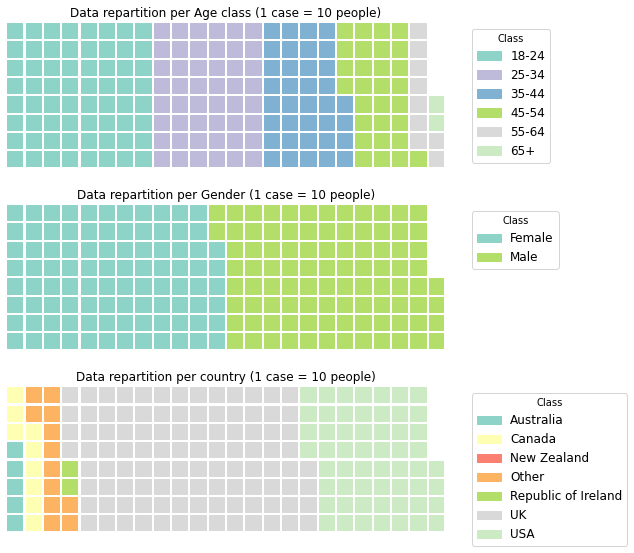

In [9]:
dfage=df.groupby('age').size().reset_index(name='counts')
dfsex=df.groupby('gender').size().reset_index(name='counts')
dfcountry=df.groupby('country').size().reset_index(name='counts')


dfage["counts"]=dfage["counts"]/10
dfsex["counts"]=dfsex["counts"]/10
dfcountry["counts"]=dfcountry["counts"]/10


cate = dfage.shape[0]
cate2= dfsex.shape[0]
cate3= dfcountry.shape[0]


colors = [plt.cm.Set3(i/float(cate)) for i in range(cate)]
colors2 = [plt.cm.Set3(i/float(cate2)) for i in range(cate2)]
colors3 = [plt.cm.Set3(i/float(cate3)) for i in range(cate3)]


fig = plt.figure(
    FigureClass=Waffle,
    rows=8,
    figsize=(10, 8),
    plots={
        '311': {
            'values': dfage['counts'],
            'labels': ["{1}".format(n[0], n[1]) for n in dfage[['age', 'counts']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Class'},
            'title': {'label': 'Data repartition per Age class (1 case = 10 people)', 'loc': 'center', 'fontsize':12},
            'colors': colors
        },
        '312': {
            'values': dfsex['counts'],
            'labels': ["{1}".format(n[0], n[1]) for n in dfsex[['gender', 'counts']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Class'},
            'title': {'label': 'Data repartition per Gender (1 case = 10 people)', 'loc': 'center', 'fontsize':12},
            'colors': colors2
        },
        '313': {
            'values': dfcountry['counts'],
            'labels': ["{1}".format(n[0], n[1]) for n in dfcountry[['country', 'counts']].itertuples()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 12, 'title':'Class'},
            'title': {'label': 'Data repartition per country (1 case = 10 people)', 'loc': 'center', 'fontsize':12},
            'colors': colors3
        },
    },
)     

In [10]:
df.groupby("age").agg({"nscore":(np.average,np.std),"escore":(np.average,np.std),"oscore":(np.average,np.std),"ascore":(np.average,np.std),"cscore":(np.average,np.std)})

nscore               escore               oscore            \
         average       std    average       std    average       std   
age                                                                    
18-24  37.041991  9.421248  39.662519  7.249854  47.825816  6.241317   
25-34  36.515593  9.216169  39.943867  7.064212  45.490644  6.869347   
35-44  35.822535  8.909434  39.002817  6.341282  44.008451  6.429754   
45-54  33.965986  8.271762  39.765306  6.066977  44.268707  5.872877   
55-64  32.419355  8.283460  39.258065  5.725426  44.623656  6.490652   
65+    31.833333  9.319493  36.722222  4.169999  40.833333  8.576644   

          ascore               cscore            
         average       std    average       std  
age                                              
18-24  42.264386  6.517536  39.494557  7.413754  
25-34  43.029106  6.842513  41.962578  6.685078  
35-44  42.777465  5.994211  42.425352  6.600114  
45-54  44.149660  6.026510  43.057823  6.133892  
55-64  42.655914  6.013562  42.440860  6.323631  
65+    42.222222  7.191135  45.611111  5.370276

In [11]:
df.groupby("gender").agg({"nscore":np.average,"escore":np.average,"oscore":np.average,"ascore":np.average,"cscore":np.average})

,nscore,escore,oscore,ascore,cscore
gender,,,,,
Female,36.562168,39.994687,44.829968,44.293305,42.719447
Male,35.278897,39.162248,46.628844,41.448568,40.156946


In [12]:
dfAD=df.groupby(["age","ecstasy"]).size().unstack(fill_value=0).stack().reset_index(name='counts')
dfAD=dfAD.set_index(["age","ecstasy"])
dfAD.head(10)


counts
age   ecstasy                       
18-24 Never Used                 247
      Used in Last Day            16
      Used in Last Decade         70
      Used in Last Month         101
      Used in Last Week           36
      Used in Last Year          172
      Used over a Decade Ago       1
25-34 Never Used                 240
      Used in Last Day             2
      Used in Last Decade         85

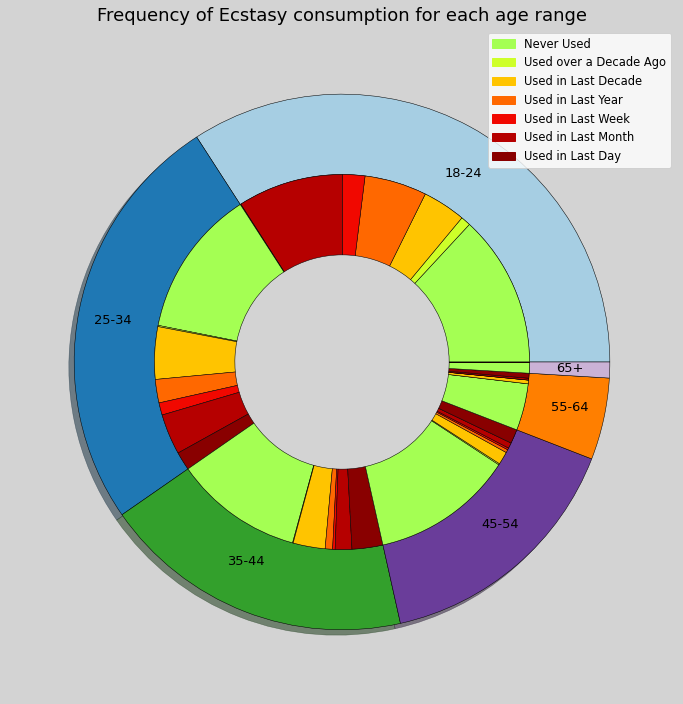

In [13]:
color = plt.cm.jet
color2= plt.cm.Paired

outer_colors = [color2(0),color2(0.15),color2(0.30),color2(0.8),color2(0.6),color2(0.7)]
inner_colors = [color(.55), color(.6), color(.7), color(.8), color(.9), color(.95), color(0.99)]*7
                
    
label1 = list(['18-24','25-34','35-44','45-54','55-64','65+'])
label2=list(['Never Used','Used in Last Day','Used in Last Decade','Used in Last Month','Used in Last Week','Used in Last Year','Used over a Decade Ago'])*6
size = 0.3
vals = dfAD['counts']
group_sum = dfAD.groupby('age')['counts'].sum()


fig, ax = plt.subplots(figsize=(12,16), facecolor="lightgrey")
        
ax.pie(group_sum, 
       radius=1,
       labels=label1,
       colors=outer_colors,
       labeldistance=0.8,
       textprops={'fontsize': 13},
       shadow = True,
       wedgeprops=dict(width=size, edgecolor='black',linewidth=0.5))

ax.pie(vals, 
       radius=1-size,
       colors=inner_colors,
       wedgeprops=dict(width=size, edgecolor='black',linewidth=0.5))

ax.set_title('Frequency of Ecstasy consumption for each age range',fontsize=18)


a = mpatches.Patch(color=inner_colors[0], label='Never Used')
b = mpatches.Patch(color=inner_colors[1], label='Used over a Decade Ago')
c = mpatches.Patch(color=inner_colors[2], label='Used in Last Decade')
d = mpatches.Patch(color=inner_colors[3], label='Used in Last Year')
e = mpatches.Patch(color=inner_colors[4], label='Used in Last Week')
f = mpatches.Patch(color=inner_colors[5], label='Used in Last Month')
g = mpatches.Patch(color=inner_colors[6], label='Used in Last Day')
plt.legend(handles=[a,b,c,d,e,f,g],prop={'size': 11.5})


In [14]:
world=geo.read_file(geo.datasets.get_path('naturalearth_lowres'))

dfw=df[["country","alcohol"]]
dfw["alcohol"]=dfw["alcohol"].apply(lambda x: 1 if x in ("Used in Last Week","Used in Last Day","Used in Last Month") else 0)
dfw=dfw.groupby(["country"]).agg({"alcohol":["sum","count"]})
dfw['prop']=round(dfw['alcohol','sum']/dfw['alcohol','count']*100,2)
dfw.reset_index(inplace=True)

dfw["country"]=dfw["country"].apply(lambda x: 'Ireland' if x=='Republic of Ireland' else x)
dfw["country"]=dfw["country"].apply(lambda x: 'United Kingdom' if x=='UK' else x)
dfw["country"]=dfw["country"].apply(lambda x: 'United States of America' if x=='USA' else x)

dfw=world.merge(dfw,how='left',left_on=['name'],right_on=['country'])
dfw.dropna(inplace=True)
dfw.columns = ['pop', 'continent', 'name', 'iso_a3', 'gdp_md_est','geometry','country','sum','count','prop']



mapdrug = folium.Map()

# Add the data
folium.Choropleth(
    geo_data=dfw,
    name='choropleth',
    data=dfw,
    columns=['country', 'prop'],
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Percentage of People who have drink alchool during the last Month per Country'
).add_to(mapdrug)

mapdrug


NameError: name 'geo' is not defined

In [53]:
nbUK=df.groupby("country").size()["UK"]
nbUSA=df.groupby("country").size()["USA"]

dfUSA=df[df["country"]=="USA"]
dfUK=df[df["country"]=="UK"]

drug_list=["alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke","crack","ecstasy","heroin","ketamine","legalh",
          "lsd","meth","mushrooms","nicotine","vsa"]

for i in drug_list:
    dfUK[i].replace(User, inplace=True)
    dfUSA[i].replace(User, inplace=True)

dfUSA = dfUSA.drop(dfUSA.columns[0:12], 1)
dfUSA=dfUSA.drop("semer",1)

dfUK = dfUK.drop(dfUK.columns[0:12], 1)
dfUK=dfUK.drop("semer",1)

labels=dfUSA.columns

valuesUSA=[]
valuesUK=[]

for i in labels :
    try :
        valuesUSA.append(dfUSA[i].value_counts()["User"])
    except :
        valuesUSA.append(0)
        
    try : 
        valuesUK.append(dfUK[i].value_counts()["User"])
    except :
        valuesUK.append(0)

#Conversion pourcentages : 
def convPourcentage (liste,nb):
    for i in range(len(liste)):
        liste[i]=round(liste[i]*100/nb,1)
    return liste

valuesUSA=convPourcentage(valuesUSA,nbUSA)
valuesUK=convPourcentage(valuesUK,nbUK)

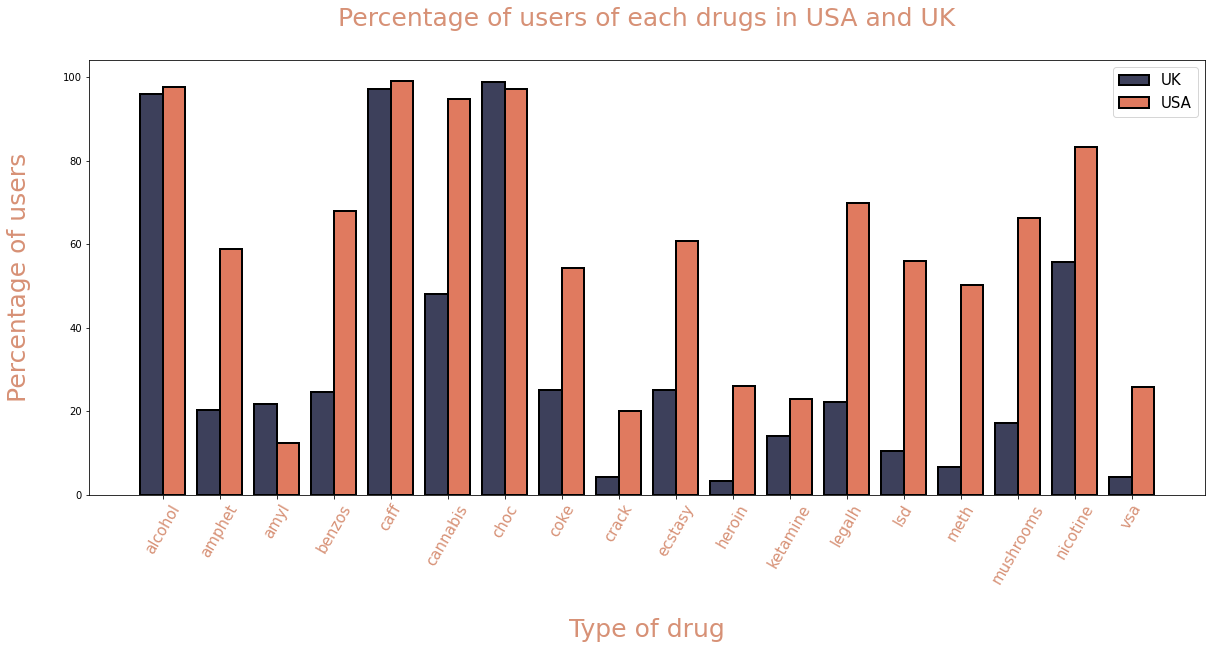

In [54]:
largeur_barre = 0.4 

plt.figure(figsize=(20,8))

x1 = range(len(valuesUK)) # Position des barres de la catégorie 1

x2 = [i + largeur_barre for i in x1] # Position des barres de la cat 2


plt.bar(x1, valuesUK, width = largeur_barre, color = '#3d405b', # Barres cat 1

           edgecolor = 'black', linewidth = 2)

plt.bar(x2, valuesUSA, width = largeur_barre, color = '#e07a5f', # Barres cat 2

           edgecolor = ['black' for i in valuesUK], linewidth = 2)

plt.xticks([r + largeur_barre / 2 for r in range(len(valuesUK))], # Etiquettes

              labels)
plt.xlabel('\nType of drug', fontsize=25, color='#D79176')
plt.xticks(rotation= 60, fontsize=15,color='#D79176')
plt.ylabel("Percentage of users\n", fontsize=25, color='#D79176')
plt.title("Percentage of users of each drugs in USA and UK\n",fontsize=25, color='#D79176')
plt.legend(["UK","USA"],loc='upper right',fontsize=15)

Drug users analysis : 

In [27]:
dfMostUsedDrug=df.copy()
dfMostUsedDrug.drop(columns=['caff', 'choc','legalh','mushrooms','nicotine','alcohol',],inplace=True)

drugList=['amphet','amyl', 'benzos', 'cannabis', 'coke', 'crack', 'ecstasy', 'heroin','ketamine', 'lsd', 'meth', 'vsa']
drugCount={}


for i in drugList:
    dfMostUsedDrug[i]=dfMostUsedDrug[i].map(User)
    drugCount[i]=dfMostUsedDrug[i].value_counts()["User"]

drugCount=sorted(drugCount.items(), key=lambda t: t[1])


names=[]
values= []

for i in drugCount :
    names.append(i[0])
    values.append(round((i[1]/len(dfMostUsedDrug))*100,2))


    

Text(0.5, 1.0, 'Percentage of users for each illegal drug\n')

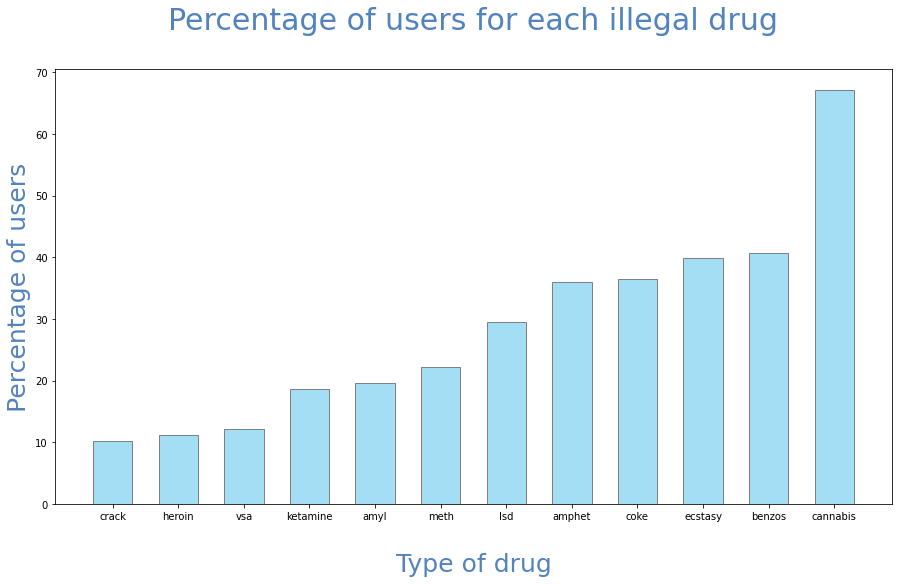

In [28]:
plt.figure(figsize=(15,8))
width_bar=0.6

plt.bar(names,values, width = width_bar, color="#a4def4", edgecolor="grey", linewidth=1)
plt.xlabel("\nType of drug", fontsize=25, color="#5383be")
plt.ylabel("Percentage of users", fontsize=25, color="#5383be")
plt.title("Percentage of users for each illegal drug\n", fontsize=30, color="#5383be")



Count the number of different drugs used : 

In [46]:
dfdd=df.copy()

dfdd.drop(columns=["age","gender","education","country","ethnicity","nscore","escore","oscore","cscore","ascore","impulsive","ss",'caff', 'choc','legalh','mushrooms','nicotine','alcohol','semer'],inplace=True)

drugList=['amphet','amyl', 'benzos', 'cannabis', 'coke', 'crack', 'ecstasy', 'heroin','ketamine', 'lsd', 'meth', 'vsa']

UserNumeric = {"User":1,"Non-user":0}

for i in drugList:
    dfdd[i]=dfdd[i].map(User)
    dfdd[i]=dfdd[i].map(UserNumeric)
 
dfdd["nbDrugs"]=dfdd.sum(axis=1)

Text(0.5, 1.0, 'Distribution of people according to the number of different drugs they use\n')

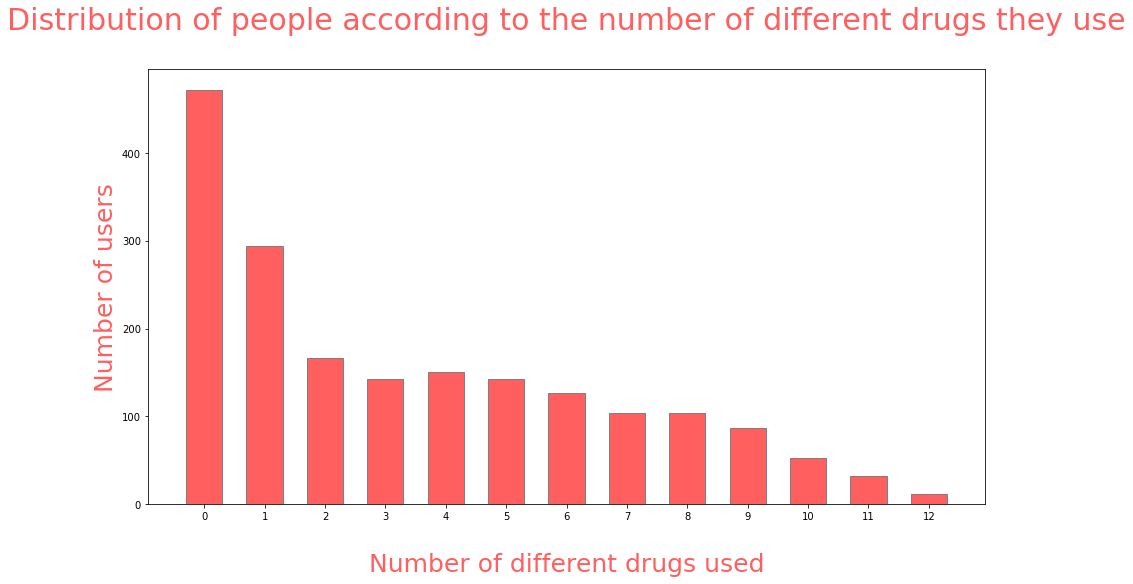

In [47]:
plt.figure(figsize=(15,8))
width_bar=0.6

plt.bar(["0","1","2","3","4","5","6","7","8","9","10","11","12"],dfdd["nbDrugs"].value_counts().sort_index(), width = width_bar, color="#ff5f5f", edgecolor="grey", linewidth=1)
plt.xlabel("\nNumber of different drugs used", fontsize=25, color="#ff5f5f")
plt.ylabel("Number of users", fontsize=25, color="#ff5f5f")
plt.title("Distribution of people according to the number of different drugs they use\n", fontsize=30, color="#ff5f5f")

Male / female repartition : 

In [48]:
dfMF=df.copy()
dfMF.drop(columns=['caff', 'choc','legalh','mushrooms','nicotine','alcohol',],inplace=True)

drugList=['amphet','amyl', 'benzos', 'cannabis', 'coke', 'crack', 'ecstasy', 'heroin','ketamine', 'lsd', 'meth', 'vsa']

for i in drugList:
    dfMF[i]=dfMF[i].map(User)

condition = ((dfMF['amphet'] != 'User') & 
             (dfMF['amyl'] != 'User') &
             (dfMF['benzos'] != 'User') &
             (dfMF['cannabis'] != 'User') &
             (dfMF['coke'] != 'User') &
             (dfMF['crack'] != 'User') &
             (dfMF['ecstasy'] != 'User') &
             (dfMF['heroin'] != 'User') &
             (dfMF['ketamine'] != 'User') &
             (dfMF['lsd'] != 'User') &
             (dfMF['meth'] != 'User') &
             (dfMF['vsa'] != 'User'))


dfMF.loc[condition, 'Drug'] = 0
dfMF.loc[~condition, 'Drug'] = 1

for i in drugList:
    dfMF.drop(columns=[i],inplace=True)

dfMF=dfMF[['Drug','gender']]

indexNames = dfMF[ dfMF['Drug'] == 0 ].index
# Delete these row indexes from dataFrame
dfMF.drop(indexNames , inplace=True)
dfMF=dfMF.drop("Drug",1)



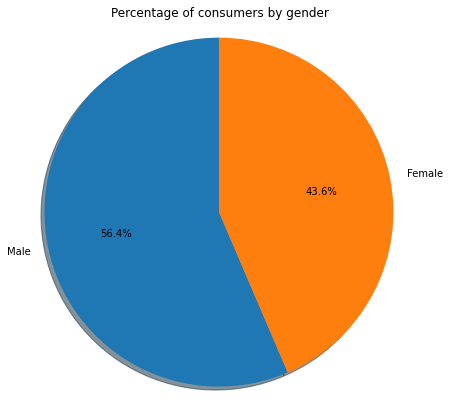

In [49]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Male','Female'
sizes = [dfMF.value_counts()[0],dfMF.value_counts()[1]]
  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots(figsize=(7,7))
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.title.set_text("Percentage of consumers by gender")
plt.show()

In [206]:
nbMale=df.groupby("gender").size()["Male"]
nbFemale=df.groupby("gender").size()["Female"]

dfMale=df[df["gender"]=="Male"]
dfFemale=df[df["gender"]=="Female"]

drug_list=["alcohol","amphet","amyl","benzos","caff","cannabis","choc","coke","crack","ecstasy","heroin","ketamine","legalh",
          "lsd","meth","mushrooms","nicotine","vsa"]

for i in drug_list:
    dfMale[i].replace(User, inplace=True)
    dfFemale[i].replace(User, inplace=True)

dfFemale = dfFemale.drop(dfFemale.columns[0:12], 1)
dfFemale.drop("semer",1)
dfMale = dfMale.drop(dfMale.columns[0:12], 1)
dfMale=dfMale.drop("semer",1)
labels=dfMale.columns

valuesFemale=[]
valuesMale=[]

for i in labels :
    try :
        valuesFemale.append(dfFemale[i].value_counts()["User"])
    except :
        valuesFemale.append(0)
        
    try : 
        valuesMale.append(dfMale[i].value_counts()["User"])
    except :
        valuesMale.append(0)

#Conversion pourcentages : 
def convPourcentage (liste,nb):
    for i in range(len(liste)):
        liste[i]=round(liste[i]*100/nb,1)
    return liste

valuesFemale=convPourcentage(valuesFemale,nbFemale)
valuesMale=convPourcentage(valuesMale,nbMale)

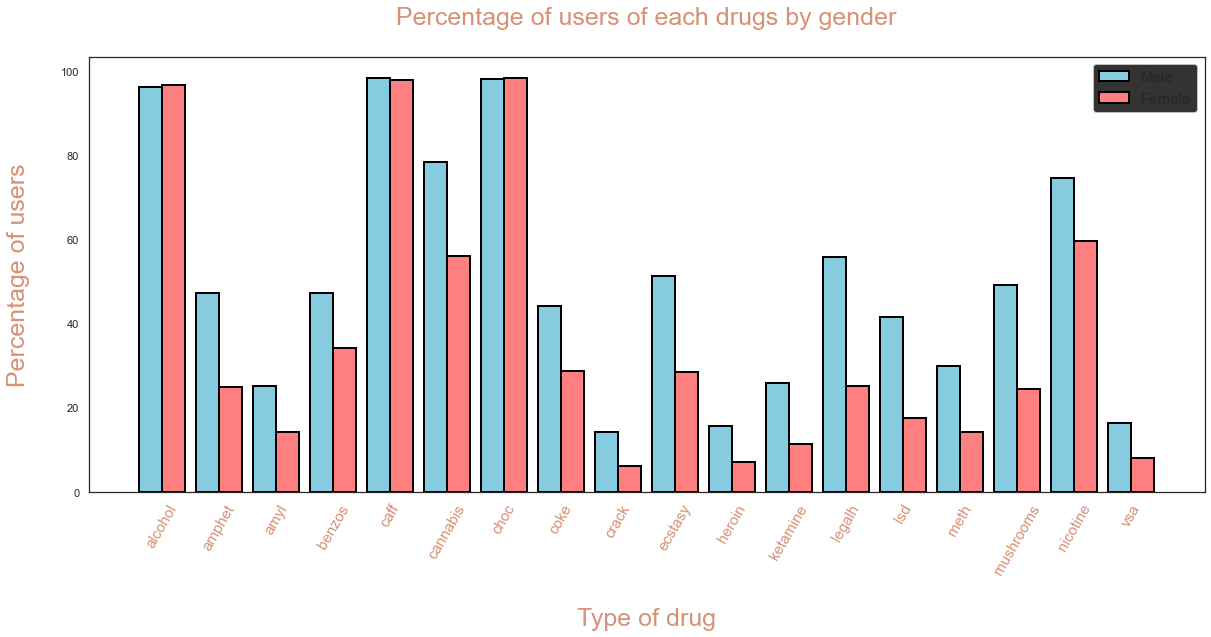

In [207]:
largeur_barre = 0.4 

plt.figure(figsize=(20,8))

x1 = range(len(valuesMale)) # Position des barres de la catégorie 1

x2 = [i + largeur_barre for i in x1] # Position des barres de la cat 2


plt.bar(x1, valuesMale, width = largeur_barre, color = '#86cbe0', # Barres cat 1

           edgecolor = 'black', linewidth = 2)

plt.bar(x2, valuesFemale, width = largeur_barre, color = '#fd7f7f', # Barres cat 2

           edgecolor = ['black' for i in valuesMale], linewidth = 2)

plt.xticks([r + largeur_barre / 2 for r in range(len(valuesMale))], # Etiquettes

              labels)
plt.xlabel('\nType of drug', fontsize=25, color='#D79176')
plt.xticks(rotation= 60, fontsize=15,color='#D79176')
plt.ylabel("Percentage of users\n", fontsize=25, color='#D79176')
plt.title("Percentage of users of each drugs by gender\n",fontsize=25, color='#D79176')
plt.legend(["Male","Female"],loc='upper right',fontsize=15)

In [208]:
dfscp=df.copy()
dfscp.drop(columns=['caff', 'choc','legalh','mushrooms','nicotine','alcohol',],inplace=True)

drugList=['amphet','amyl', 'benzos', 'cannabis', 'coke', 'crack', 'ecstasy', 'heroin','ketamine', 'lsd', 'meth', 'vsa']

for i in drugList:
    dfscp[i]=dfscp[i].map(User)

condition = ((dfscp['amphet'] != 'User') & 
             (dfscp['amyl'] != 'User') &
             (dfscp['benzos'] != 'User') &
             (dfscp['cannabis'] != 'User') &
             (dfscp['coke'] != 'User') &
             (dfscp['crack'] != 'User') &
             (dfscp['ecstasy'] != 'User') &
             (dfscp['heroin'] != 'User') &
             (dfscp['ketamine'] != 'User') &
             (dfscp['lsd'] != 'User') &
             (dfscp['meth'] != 'User') &
             (dfscp['vsa'] != 'User'))


dfscp.loc[condition, 'Drug'] = 0
dfscp.loc[~condition, 'Drug'] = 1

for i in drugList:
    dfscp.drop(columns=[i],inplace=True)

dfscp=dfscp[['Drug','nscore','oscore','cscore','ascore','escore']]

dfscp1=dfscp.loc[dfscp['Drug'] == 1.0]
dfscp0=dfscp.loc[dfscp['Drug'] == 0.0]

dfscp1=dfscp1.drop(columns=['Drug'])
dfscp0=dfscp0.drop(columns=['Drug'])


prov1 = np.concatenate([([i]*1412) for i in ['Neuroticism','Openness to experience','Conscientiousness','Agreeableness','Extraversion']], axis=0)
prov0 = np.concatenate([([i]*472) for i in ['Neuroticism','Openness to experience','Conscientiousness','Agreeableness','Extraversion']], axis=0)


dfscp1=pd.DataFrame(dfscp1.values.ravel('F'))
dfscp1['g']=prov1
dfscp1=dfscp1.rename(columns={0: "x"})


dfscp0=pd.DataFrame(dfscp0.values.ravel('F'))
dfscp0['g']=prov0
dfscp0=dfscp0.rename(columns={0: "x"})


In [209]:
dfscp.head()

,Drug,nscore,oscore,cscore,ascore,escore
id,,,,,,
2,1.0,29,55,41,48,52
3,1.0,31,40,34,32,45
4,1.0,34,46,46,47,34
5,1.0,43,43,50,41,28
6,0.0,29,35,52,55,38


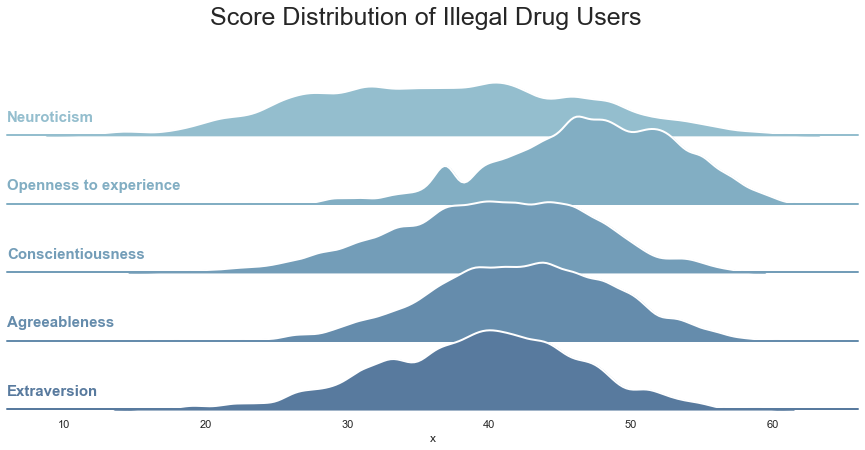

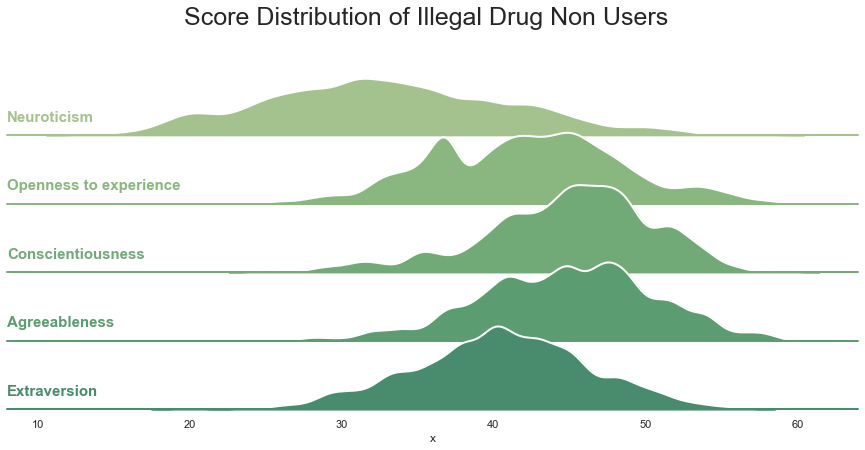

In [210]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

pal = sns.cubehelix_palette(10, rot=-0.2, light=.7)
g = sns.FacetGrid(dfscp1, row="g", hue="g", aspect=15, height=.5, palette=pal)

g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=15)


g.map(label, "x")

g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle('Score Distribution of Illegal Drug Users',fontsize=25)

plt.gcf().set_size_inches(13, 7)

plt.show()

########################################

pal = sns.cubehelix_palette(10, rot=-0.6, light=.7)
g = sns.FacetGrid(dfscp0, row="g", hue="g", aspect=15, height=.5, palette=pal)

g.map(sns.kdeplot, "x",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
g.map(label, "x")

g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.fig.suptitle('Score Distribution of Illegal Drug Non Users',fontsize=25)

plt.gcf().set_size_inches(13, 7)




## 3. Machine Learning <a class="anchor" id="chapter3"></a>



### a/ Dataset <a class="anchor" id="section_3_1"></a>

In [211]:
print(df["ecstasy"].unique())

['Used in Last Month' 'Never Used' 'Used over a Decade Ago'
 'Used in Last Year' 'Used in Last Decade' 'Used in Last Day'
 'Used in Last Week']


In [212]:
dfml=df.copy()
dfml.drop(columns=['caff', 'choc','legalh','mushrooms','nicotine','alcohol',],inplace=True)
dfml["semer"]=dfml["semer"].apply(lambda x: 1 if x in ('Used in Last Month', 'Used over a Decade Ago','Used in Last Year', 'Used in Last Decade', 'Used in Last Day','Used in Last Week') else 0)
dfml.drop(dfml[dfml['semer']==1].index, inplace=True)
#8 liers have been removed

dfml.drop(columns=['semer'],inplace=True)
drugList=['amphet','amyl', 'benzos', 'cannabis', 'coke', 'crack', 'ecstasy', 'heroin','ketamine', 'lsd', 'meth', 'vsa']
for i in drugList:
    dfml[i]=dfml[i].map(User)




condition = ((dfml['amphet'] != 'User') & 
             (dfml['amyl'] != 'User') &
             (dfml['benzos'] != 'User') &
             (dfml['cannabis'] != 'User') &
             (dfml['coke'] != 'User') &
             (dfml['crack'] != 'User') &
             (dfml['ecstasy'] != 'User') &
             (dfml['heroin'] != 'User') &
             (dfml['ketamine'] != 'User') &
             (dfml['lsd'] != 'User') &
             (dfml['meth'] != 'User') &
             (dfml['vsa'] != 'User'))


dfml.loc[condition, 'Drug'] = 0
dfml.loc[~condition, 'Drug'] = 1

for i in drugList:
    dfml.drop(columns=[i],inplace=True)

dfml.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,Drug
id,,,,,,,,,,,,,
2,25-34,Male,Doctorate degree,UK,White,29,52,55,48,41,-0.71126,-0.21575,1.0
3,35-44,Male,Professional certificate/ diploma,UK,White,31,45,40,32,34,-1.37983,0.40148,1.0
4,18-24,Female,Masters degree,UK,White,34,34,46,47,46,-1.37983,-1.18084,1.0
5,35-44,Female,Doctorate degree,UK,White,43,28,43,41,50,-0.21712,-0.21575,1.0
6,65+,Female,Left school at 18 years,Canada,White,29,38,35,55,52,-1.37983,-1.54858,0.0


In [213]:
#Then we replace other cateorical variables by continuous value.

dfml["age"]=dfml["age"].apply(lambda x: random.randrange(25, 34) if x=='25-34' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(18, 24) if x=='18-24' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(35, 44) if x=='35-44' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(45, 54) if x=='45-54' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(55, 64) if x=='55-64' else x)
dfml["age"]=dfml["age"].apply(lambda x: random.randrange(65, 100) if x=='65+' else x)

edu_dict = {
    "Left school before 16 years": 0,
    "Left school at 16 years":1,
    'Left school at 17 years':2,
    "Left school at 18 years":3,
    "Some college or university, no certificate or degree":4,
    "Professional certificate/ diploma":5,
    "University degree":6,
    "Masters degree":7,
    "Doctorate degree":8
    }

dfml["gender"] = dfml["gender"].astype('category')
dfml["gender"] = dfml["gender"].cat.codes

dfml["country"] = dfml["country"].astype('category')
dfml["country"] = dfml["country"].cat.codes

dfml['Drug']=pd.to_numeric(dfml['Drug'],downcast='integer').astype('category')
dfml["education"].replace(edu_dict, inplace=True)
dfml.head()

,age,gender,education,country,ethnicity,nscore,escore,oscore,ascore,cscore,impulsive,ss,Drug
id,,,,,,,,,,,,,
2,29,1,8,5,White,29,52,55,48,41,-0.71126,-0.21575,1
3,36,1,5,5,White,31,45,40,32,34,-1.37983,0.40148,1
4,23,0,7,5,White,34,34,46,47,46,-1.37983,-1.18084,1
5,41,0,8,5,White,43,28,43,41,50,-0.21712,-0.21575,1
6,85,0,3,1,White,29,38,35,55,52,-1.37983,-1.54858,0


### Variance Treshold <a class="anchor" id="section_3_1_1"></a>

In [214]:
X=dfml.drop('Drug', axis=1)
X.var(axis=0)



age          171.885167
gender         0.250132
education      3.114110
country        1.985415
nscore        83.535303
escore        45.879895
oscore        43.837940
ascore        41.399440
cscore        48.568173
impulsive      0.910857
ss             0.925346
dtype: float64

### Get Dummies & Scaled Data <a class="anchor" id="section_3_1_2"></a>

In [215]:
dfml=pd.get_dummies(dfml,columns=['gender', 'country',"ethnicity"])


#Finally we scaled the data
dfml = pd.DataFrame(MinMaxScaler().fit_transform(dfml), columns=dfml.columns)
dfml.head()

,age,education,nscore,escore,oscore,ascore,cscore,impulsive,ss,Drug,...,country_4,country_5,country_6,ethnicity_Asian,ethnicity_Black,ethnicity_Mixed-Black/Asian,ethnicity_Mixed-White/Asian,ethnicity_Mixed-White/Black,ethnicity_Other,ethnicity_White
0,0.135802,1.000,0.354167,0.837209,0.861111,0.750000,0.571429,0.337920,0.465658,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.222222,0.625,0.395833,0.674419,0.444444,0.416667,0.404762,0.215401,0.619957,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.061728,0.875,0.458333,0.418605,0.611111,0.729167,0.690476,0.215401,0.224398,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.283951,1.000,0.645833,0.279070,0.527778,0.604167,0.785714,0.428474,0.465658,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.827160,0.375,0.354167,0.511628,0.305556,0.895833,0.833333,0.215401,0.132468,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Removing Correlated Features <a class="anchor" id="section_3_1_3"></a>

In [216]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = dfml.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,education,nscore,escore,oscore,ascore,cscore,impulsive,ss,Drug,gender_0,gender_1,country_0,country_1,country_2,country_3,country_4,country_5,country_6,ethnicity_Asian,ethnicity_Black,ethnicity_Mixed-Black/Asian,ethnicity_Mixed-White/Asian,ethnicity_Mixed-White/Black,ethnicity_Other,ethnicity_White
age,1.000000,0.067549,-0.147649,-0.032592,-0.204609,0.064069,0.181357,-0.174011,-0.320765,-0.353082,0.078229,-0.078229,-0.033006,0.025894,-0.027368,-0.084328,-0.012982,0.300062,-0.276418,-0.014711,0.012192,-0.028924,-0.042097,-0.044128,-0.061340,0.074398
education,0.067549,1.000000,-0.092712,0.117888,0.080950,0.081205,0.223855,-0.113934,-0.108718,-0.161029,0.189440,-0.189440,-0.028989,-0.065491,-0.023301,-0.025430,-0.037964,0.200071,-0.152815,0.082000,0.039437,-0.007453,0.009328,0.015363,-0.001187,-0.059083
nscore,-0.147649,-0.092712,1.000000,-0.433354,0.014574,-0.215791,-0.400253,0.176288,0.083204,0.184081,0.068469,-0.068469,-0.010526,0.024225,0.019712,-0.016835,-0.010404,-0.133634,0.147477,0.009720,-0.041369,0.028109,0.035891,0.007924,-0.001886,-0.003032
escore,-0.032592,0.117888,-0.433354,1.000000,0.234266,0.159563,0.318260,0.107487,0.202581,-0.079964,0.062208,-0.062208,0.012257,-0.040520,-0.034858,-0.028467,0.033478,0.116694,-0.101438,0.017744,0.006778,0.014385,0.025350,0.011198,0.019772,-0.038181
oscore,-0.204609,0.080950,0.014574,0.234266,1.000000,0.030415,-0.061710,0.271292,0.416727,0.309066,-0.138524,0.138524,0.029894,-0.021063,0.011616,0.107769,0.003722,-0.320808,0.289316,-0.025154,-0.060964,0.015845,0.021280,-0.014912,0.065686,-0.007549
ascore,0.064069,0.081205,-0.215791,0.159563,0.030415,1.000000,0.247841,-0.232311,-0.213486,-0.179635,0.220468,-0.220468,0.003989,-0.064803,0.007496,-0.076913,0.006176,0.164855,-0.112598,-0.003383,0.018520,-0.042726,0.000432,0.012846,-0.017045,0.004920
cscore,0.181357,0.223855,-0.400253,0.318260,-0.061710,0.247841,1.000000,-0.343798,-0.234337,-0.287601,0.182376,-0.182376,-0.028743,0.006572,-0.006203,-0.090585,-0.024376,0.215149,-0.172894,0.008073,0.039349,-0.036970,-0.000982,0.012772,0.023524,-0.035727
impulsive,-0.174011,-0.113934,0.176288,0.107487,0.271292,-0.232311,-0.343798,1.000000,0.622604,0.289475,-0.169441,0.169441,0.041024,0.009725,-0.001755,0.028156,-0.023277,-0.218854,0.209908,-0.007796,-0.041662,0.048227,0.028753,0.014610,0.052322,-0.033029
ss,-0.320765,-0.108718,0.083204,0.202581,0.416727,-0.213486,-0.234337,0.622604,1.000000,0.367272,-0.245946,0.245946,0.066893,0.010490,0.017979,0.075702,0.024827,-0.334057,0.287479,-0.028594,-0.067073,0.031267,0.014177,0.000781,0.081559,-0.018675
Drug,-0.353082,-0.161029,0.184081,-0.079964,0.309066,-0.179635,-0.287601,0.289475,0.367272,1.000000,-0.222352,0.222352,0.067967,0.046083,0.029973,0.094560,0.024305,-0.409380,0.341535,-0.071883,-0.118650,0.023205,0.034111,0.009574,0.045347,0.037245


In [217]:
#From the previous matrix, we understand that we have to drop one of the gender column because obviously they are correlated 
#due to the fact that there are only 2 differents categories ( male of female)

dfml=dfml.drop('gender_0', axis=1)

### b. Supervised learning Model  <a class="anchor" id="section_3_2"></a>


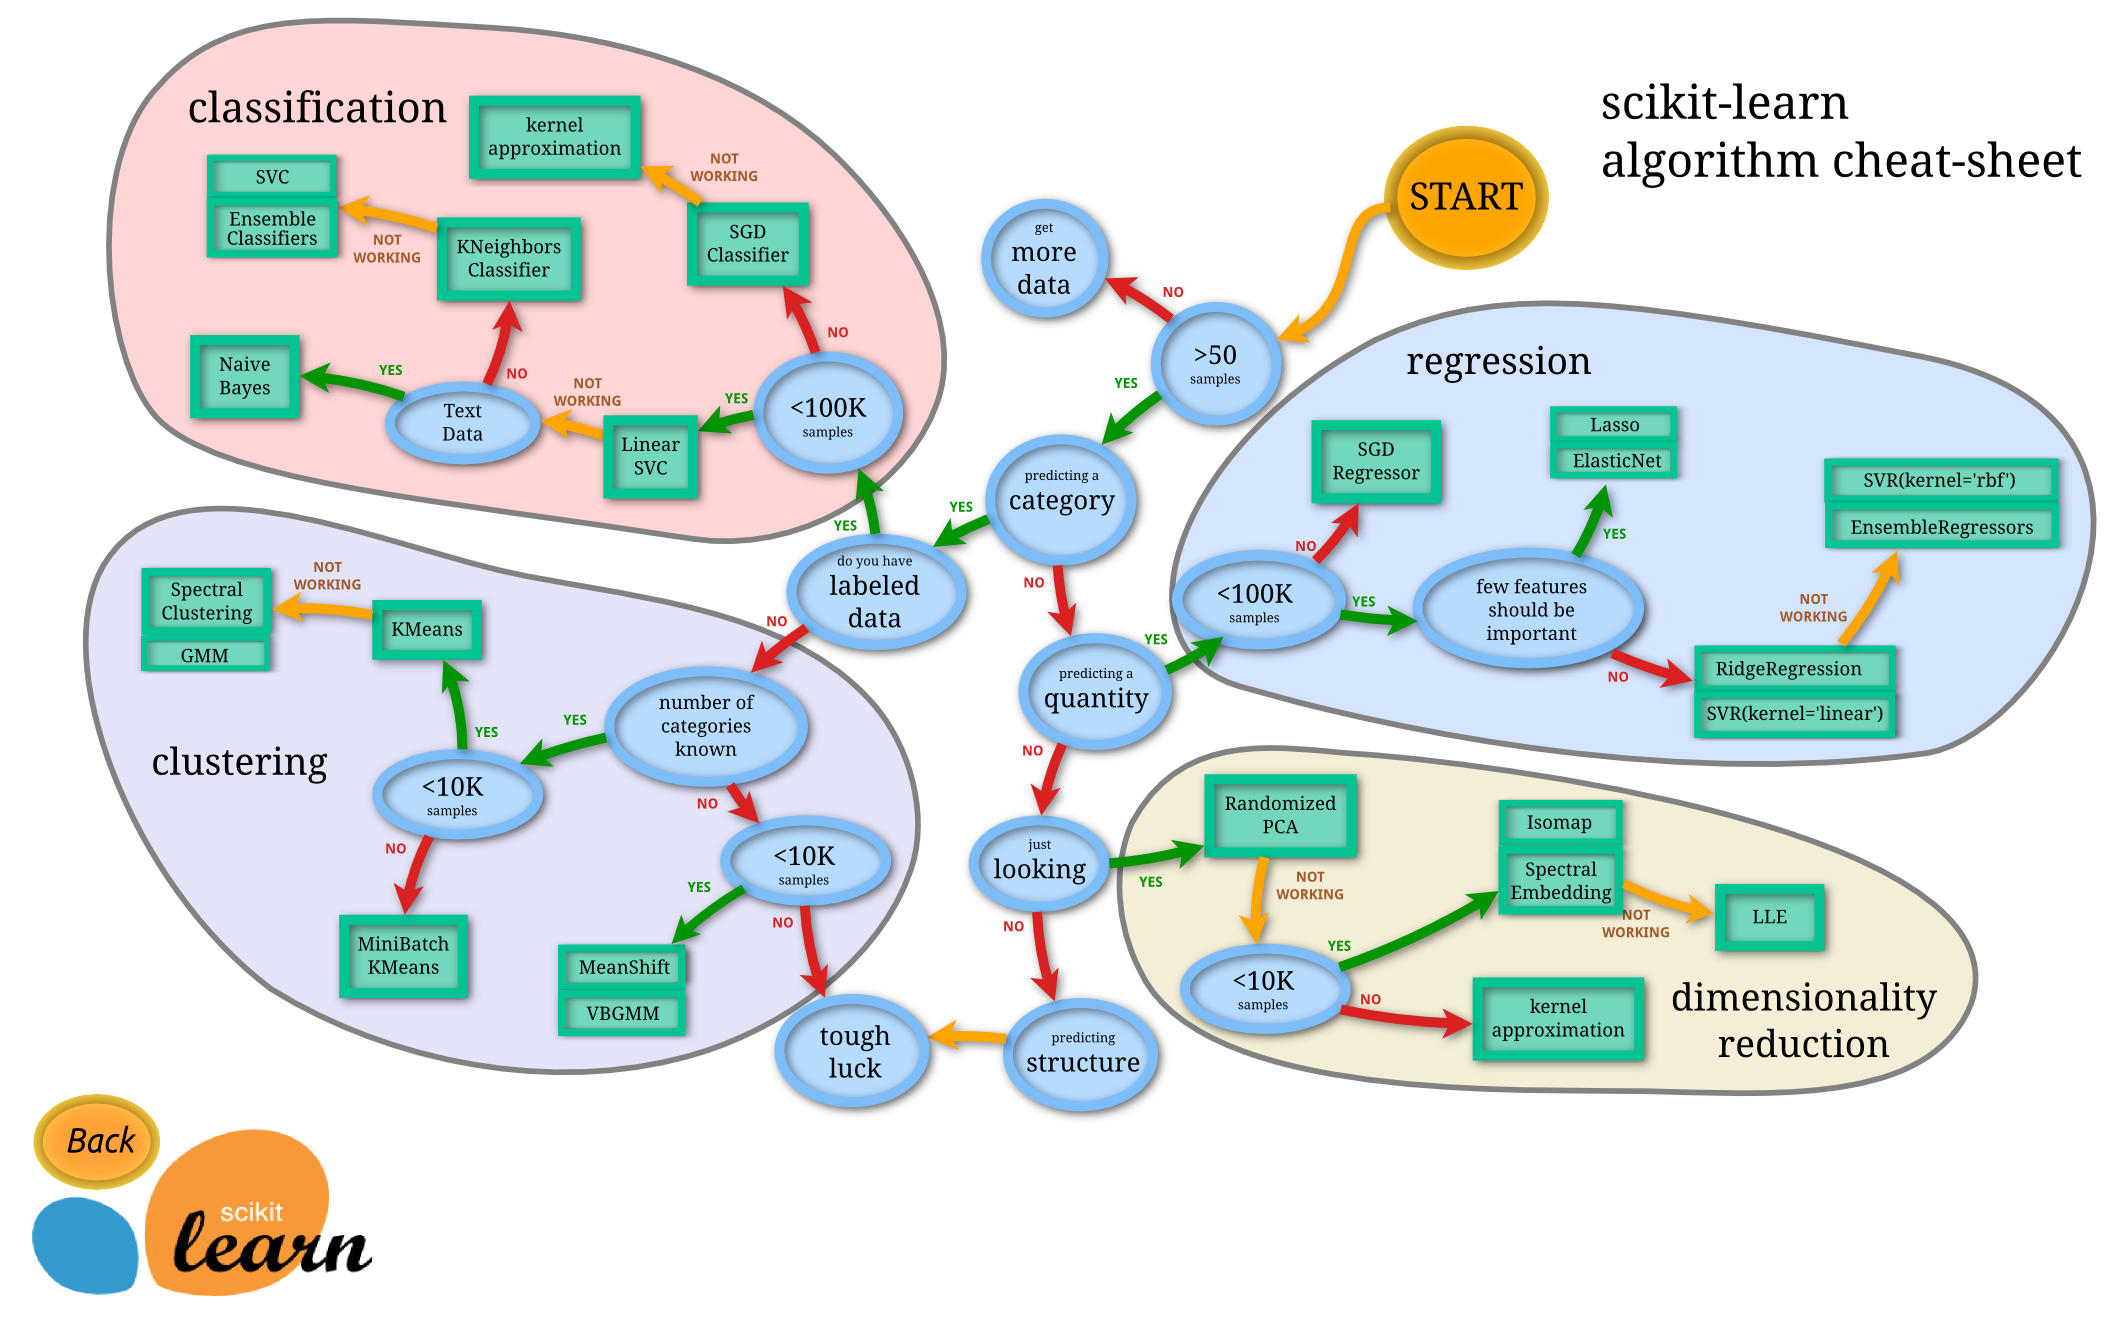

In [218]:
Image("https://scikit-learn.org/stable/_static/ml_map.png")

In [219]:
print(len(dfml))

1876


### Linear SVC <a class="anchor" id="section_3_2_1"></a>

#### 1. Normal <a class="anchor" id="section_3_2_1_1"></a>

In [220]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


model= LinearSVC()
LinearSVC_normal_score= cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy').mean()

print("Accuracy basic LinearSVC :", LinearSVC_normal_score)

Accuracy basic LinearSVC : 0.8173333333333334


#### 2. Optimization - Recursive Feature Elimination and Grid Search <a class="anchor" id="section_3_2_1_2"></a>

Optimal number of features:  19


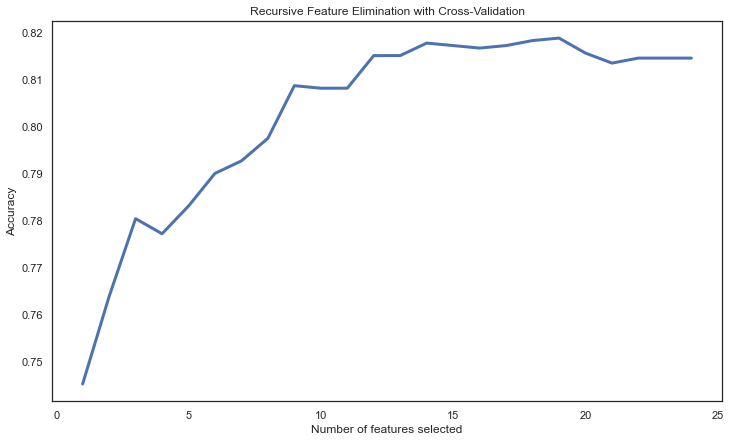

In [221]:
# It could be interesting to drop useless features to try to optimize the performance of our model.
# To do that, we will use the RFECV method

rfecv=RFECV(estimator=model,step=1,cv=StratifiedKFold(10),scoring='accuracy')
rfecv.fit(X, y)
print('Optimal number of features: ',rfecv.n_features_)


plt.figure(figsize=(12, 7))
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of features selected')
plt.ylabel('Accuracy')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)

plt.show()

In [222]:
column = dict(zip(X.columns,rfecv.support_))
#This the list of features we will drop

filtered = [k for k,v in column.items() if v == False]
filtered

['country_0',
 'country_1',
 'country_4',
 'ethnicity_Mixed-Black/Asian',
 'ethnicity_Other']

In [223]:
filtered.append('Drug')
X=dfml.drop(filtered, axis=1)
y=dfml["Drug"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



tuned_parameters = {'C':np.arange(0,10,0.1)}

grid=GridSearchCV(LinearSVC(),tuned_parameters,cv=5)
grid.fit(X_train,y_train)
grid.best_score_
grid.best_params_

model=grid.best_estimator_

LinearSVC_opti_score=model.score(X_test, y_test)
print("Accuracy modified LinearSVC:", model.score(X_test, y_test))
print("The accuracy doesn't improved due to the fact that Liblinear always failed to converge during the GridSearch")






Accuracy modified LinearSVC: 0.8191489361702128
The accuracy doesn't improved due to the fact that Liblinear always failed to converge during the GridSearch


### KNeighborsClassifier <a class="anchor" id="section_3_2_2"></a>

#### 1. Normal <a class="anchor" id="section_3_2_2_1"></a>

In [224]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model= KNeighborsClassifier()
KNN_normal_score= cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy').mean()

print("Accuracy basic KNN :", KNN_normal_score)

Accuracy basic KNN : 0.7886666666666666


#### 2. Optimization - Grid Search <a class="anchor" id="section_3_2_2_2"></a>

In [225]:
tuned_parameters={'n_neighbors':np.arange(30,50,5),'leaf_size' : np.arange(1,10,2),'p':[1,2]}

grid=GridSearchCV(KNeighborsClassifier(),tuned_parameters,cv=5)
grid.fit(X_train,y_train)
print(grid.best_params_)

model=grid.best_estimator_
KNN_opti_score=model.score(X_test, y_test)
print("Accuracy modified KNN:", model.score(X_test, y_test))

{'leaf_size': 1, 'n_neighbors': 40, 'p': 1}
Accuracy modified KNN: 0.7978723404255319


### SVC <a class="anchor" id="section_3_2_3"></a>

#### 1. Normal <a class="anchor" id="section_3_2_3_1"></a>

In [226]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model= SVC()
SVC_normal_score= cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy').mean()

print("Accuracy basic SVC :", SVC_normal_score)

Accuracy basic SVC : 0.8166666666666667


#### 2. Optimization - Recursive Feature Elimination and Grid Search <a class="anchor" id="section_3_2_3_2"></a>

Optimal number of features : 14


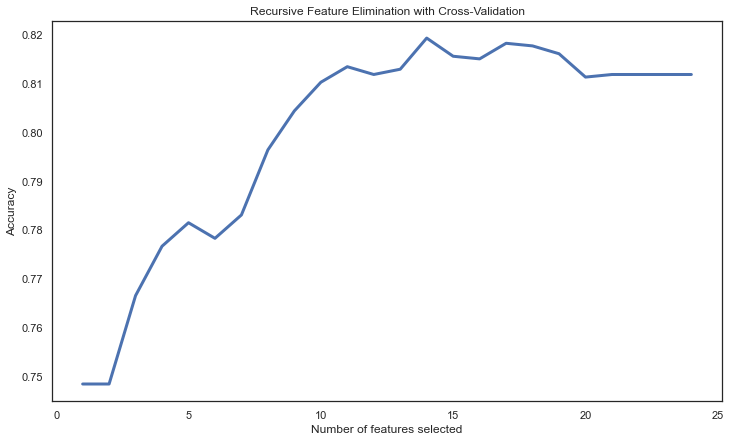

In [227]:
rfecv = RFECV(
    estimator=SVC(kernel='linear'),
    step=1,
    cv=StratifiedKFold(10),
    scoring="accuracy",
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

plt.figure(figsize=(12, 7))
plt.title('Recursive Feature Elimination with Cross-Validation')
plt.xlabel('Number of features selected')
plt.ylabel('Accuracy')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, linewidth=3)
plt.show()

In [228]:
column = dict(zip(X.columns,rfecv.support_))
#This the list of features we will drop

filtered = [k for k,v in column.items() if v == False]
filtered

['gender_1',
 'country_1',
 'country_2',
 'country_3',
 'country_4',
 'ethnicity_Mixed-Black/Asian',
 'ethnicity_Mixed-White/Asian',
 'ethnicity_Mixed-White/Black',
 'ethnicity_Other',
 'ethnicity_White']

In [229]:
filtered.append('Drug')
X=dfml.drop(filtered, axis=1)
y=dfml["Drug"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)



tuned_parameters={'kernel' : ['poly'],
                 'gamma' : [0.8,0.9,0.7],
                 'C': [1,2,3,4],
                 'degree' : [0,1,2]}

grid=GridSearchCV(SVC(),tuned_parameters,cv=5)
grid.fit(X_train,y_train)
print(grid.best_params_)

model=grid.best_estimator_
SVC_opti_score=model.score(X_test, y_test)
print("Accuracy modified SVC:", model.score(X_test, y_test))

{'C': 1, 'degree': 1, 'gamma': 0.9, 'kernel': 'poly'}
Accuracy modified SVC: 0.800531914893617


### Random Forest <a class="anchor" id="section_3_2_4"></a>

#### 1. Normal <a class="anchor" id="section_3_2_4_1"></a>

In [230]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model= RandomForestClassifier()
RF_normal_score= cross_val_score(model, X_train, y_train, cv=5,scoring='accuracy').mean()

print("Accuracy basic Random Forest :", RF_normal_score)

Accuracy basic Random Forest : 0.8160000000000001


#### 2.Optimization - Feature Elimination and Grid Search <a class="anchor" id="section_3_2_4_2"></a>

No handles with labels found to put in legend.


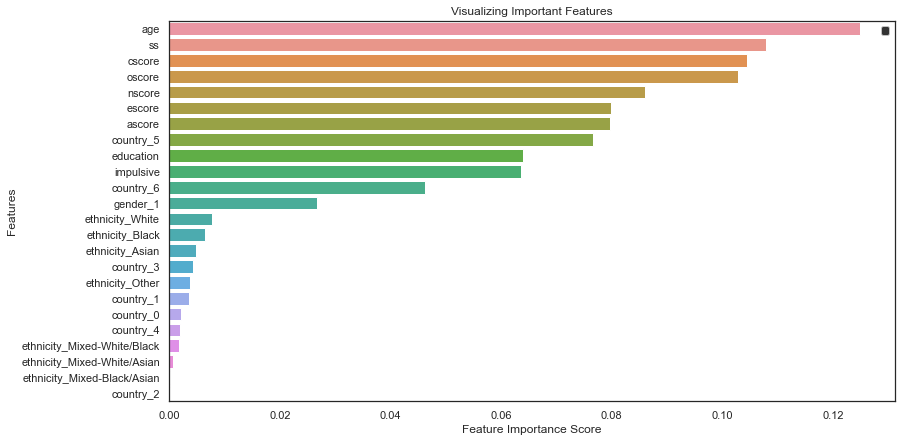

In [231]:
X=dfml.drop('Drug', axis=1)
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.gcf().set_size_inches(13, 7)
plt.show()

In [232]:
X=dfml[['age','oscore','cscore','ss','nscore','country_5','ascore','escore','impulsive','education','country_6','gender_1']]
y=dfml["Drug"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

n_estimators = [5,10,15]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10]

param = dict(n_estimators = n_estimators, max_depth = max_depth,  
             min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = GridSearchCV(RandomForestClassifier(), param, cv = 3, verbose = 1, n_jobs = -1)

grid.fit(X_train,y_train)
print(grid.best_params_)

model=grid.best_estimator_
RF_opti_score=model.score(X_test, y_test)

print("Accuracy modified Random Forest:", model.score(X_test, y_test))

Fitting 3 folds for each of 300 candidates, totalling 900 fits
{'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
Accuracy modified Random Forest: 0.7712765957446809


### c. Deep Learning <a class="anchor" id="section_3_3"></a>

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [234]:
x=len(X_train.columns)
model = tf.keras.models.Sequential([


    tf.keras.layers.Dense(x,activation='relu',input_shape=(x,)),
    tf.keras.layers.Dense(100,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(80,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(200,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(50,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(80,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(200,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(50,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),
    tf.keras.layers.Dense(20,activation='relu',kernel_initializer='he_normal',kernel_regularizer='l2'),    
    tf.keras.layers.Dense(1,activation='sigmoid'),
])


model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=["accuracy"])




In [235]:
history = model.fit(X_train, y_train, epochs=100,batch_size=5)

Epoch 1/100
300/300 [==============================] - 1s 589us/step - loss: 15.1954 - accuracy: 0.7447
Epoch 2/100
300/300 [==============================] - 0s 595us/step - loss: 13.4735 - accuracy: 0.7453
Epoch 3/100
300/300 [==============================] - 0s 604us/step - loss: 11.9783 - accuracy: 0.7460
Epoch 4/100
300/300 [==============================] - 0s 609us/step - loss: 10.6634 - accuracy: 0.7720
Epoch 5/100
300/300 [==============================] - 0s 605us/step - loss: 9.4991 - accuracy: 0.8013
Epoch 6/100
300/300 [==============================] - 0s 598us/step - loss: 8.4643 - accuracy: 0.7960
Epoch 7/100
300/300 [==============================] - 0s 599us/step - loss: 7.5650 - accuracy: 0.8120
Epoch 8/100
300/300 [==============================] - 0s 592us/step - loss: 6.7507 - accuracy: 0.8133
Epoch 9/100
300/300 [==============================] - 0s 592us/step - loss: 6.0356 - accuracy: 0.8167
Epoch 10/100
300/300 [==============================] - 0s 599us/step

In [236]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 12)                156       
                                                                 
 dense_11 (Dense)            (None, 100)               1300      
                                                                 
 dense_12 (Dense)            (None, 80)                8080      
                                                                 
 dropout_2 (Dropout)         (None, 80)                0         
                                                                 
 dense_13 (Dense)            (None, 200)               16200     
                                                                 
 dense_14 (Dense)            (None, 50)                10050     
                                                                 
 dense_15 (Dense)            (None, 80)               

Text(0.5, 1.0, 'Training and validation loss')

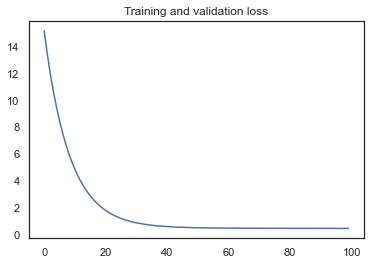

In [237]:
loss= history.history['loss']
epochs= np.arange(100)
plt.plot  ( epochs,loss )
plt.title ('Training and validation loss')

In [238]:
test_loss, DL_score = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', DL_score)

12/12 - 0s - loss: 0.4851 - accuracy: 0.7952 - 106ms/epoch - 9ms/step

Test accuracy: 0.7952127456665039


### Machine Learning Model Comparison

Text(0.5, 0, 'Accuracy')

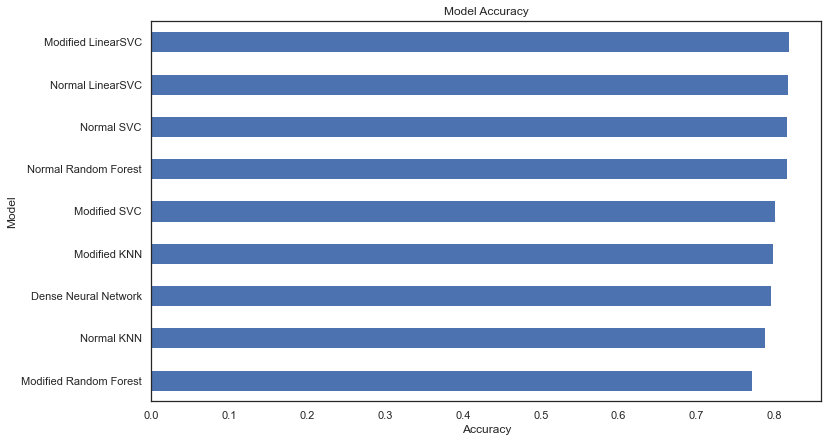

In [239]:
model_label=['Normal Random Forest','Modified Random Forest','Normal LinearSVC','Modified LinearSVC','Normal KNN','Modified KNN','Normal SVC','Modified SVC','Dense Neural Network']
model_score=[RF_normal_score,RF_opti_score,LinearSVC_normal_score,LinearSVC_opti_score,KNN_normal_score,KNN_opti_score,SVC_normal_score,SVC_opti_score,DL_score]

dfacc = pd.DataFrame()
dfacc['Model']  = model_label
dfacc['Accuracy']  = model_score
dfacc = dfacc.sort_values(by='Accuracy')
dfacc=dfacc.set_index('Model')


dfacc['Accuracy'].plot(kind="barh",figsize=(12, 7))
plt.title("Model Accuracy")
plt.xlabel("Accuracy")
